## Setting the environment

In [13]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from numpy import array

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

## Loading DataSet

In [14]:
reviews_data = pd.read_csv("final_reviews_data.csv")
reviews_data.shape

(11639, 3)

In [15]:
reviews_data.head(5)

,Sentiments,Reviews,language
0,positive,great original product with great discount,en
1,negative,trouser's stuff is good but shirt is very poor...,en
2,negative,it is not a leather jacket this is ragazine.qu...,en
3,positive,Same as picture really good fabric and i recei...,en
4,negative,This fragrance had a very short shelf life. Af...,en


In [18]:
reviews_data = reviews_data.dropna(subset=['Reviews'])

In [19]:
# Checking for missing values

reviews_data.isnull().values.any()

False

In [20]:
with open('stopwords.txt', 'r') as file:
    stopwords = {line.strip() for line in file}

<Axes: xlabel='Sentiments', ylabel='count'>

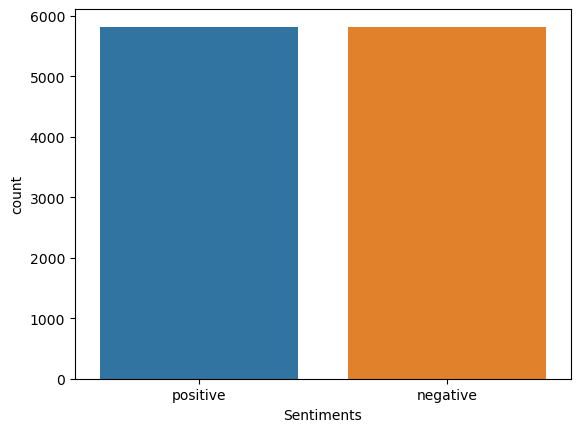

In [21]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='Sentiments', data=reviews_data)

## Data Preprocessing

In [22]:
reviews_data["Reviews"][100]
# You can see that our text contains punctuations, brackets and numbers

"it is a nice accessory and all for the 2018 iPad pro but you honestly can do without it. I personally am not going to use it that much as I thought I would. I just do not see the use if I'm not a artist or something. To be honest my S-Pen on my Galaxy Note 5 was more amazing than the Apple Pencil 2. That's just my honest opinion. I get more use out of my wireless and magnetic keyboard that came with my iPad pro case than the Pencil. I will be sending mine back and getting a refund"

In [23]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [24]:
#"not" plays an important role on reviews
contractions_dict = {
    r"don": "do not",
    r"doesn": "does not",
    r"didn": "did not",
    r"haven": "have not",
    r"hasn": "has not",
    r"hadn": "had not",
    r"won": "will not",
    r"wouldn": "would not",
    r"couldn": "could not",
    r"shouldn": "should not",
    r"mightn": "might not",
    r"mustn": "must not",
    r"weren": "were not",
    r"wasn": "was not",
    r"ain": "is not",
    r"won": "would not"
}
def expand_contractions(text):
    for contraction, expanded_form in contractions_dict.items():
        text = re.sub(contraction, expanded_form, text, flags=re.IGNORECASE)
    return text

In [25]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    #expanded forms
    sentence = expand_contractions(sentence)

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [26]:
# Calling preprocessing_text function on reviews_data

X = []
sentences = list(reviews_data['Reviews'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [27]:
# Sample cleaned up movie review 

X[100]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'nice accessory ipad pro honestly can without personally not going use much thought would not see use not artist something honest pen galaxy note amazing apple pencil honest opinion get use wireless magnetic keyboard came ipad pro case pencil sending mine back getting refund'

In [28]:
# Converting sentiment labels to 0 & 1
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, reviews_data['Sentiments'])))


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [30]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [31]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

7437

In [32]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Model Training with:

## Randoem Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

Training Accuracy : 0.9980668027064762
Testing Accuracy : 0.779639175257732


NameError: name 'plt' is not defined

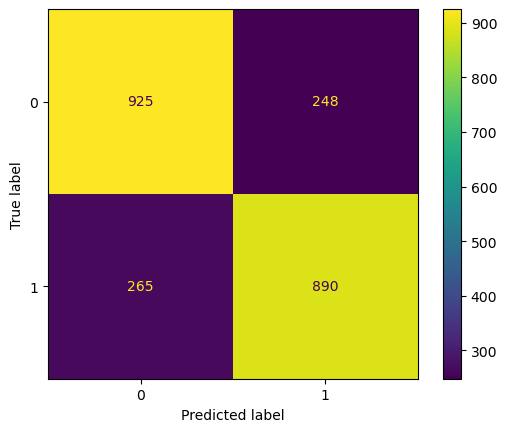

In [36]:
print("Training Accuracy :", model_rf.score(X_train, y_train))
print("Testing Accuracy :", model_rf.score(X_test, y_test))
y_preds = model_rf.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()